Relevant Feature Extraction with SHAP
===

Avicenna uses a pattern matching approach to learn and relations between input elements. Matching all input elements (features) and assosiating their relation with the program behavior is not feasible. Thus, **Avicenna** uses a machine learning model to differentiate between passing and failing inputs (based on the input properties) and then uses [SHAP]() to extract the input elements that have the highest influence on the prediction outcome.

In the following notebook, we will demonstrate how **Avicenna** extracts the most important input elements that are most likely to cause the failure.

#### Example Subject

We use our sample calculator subject to illustrate Avicenna's capabilities. Please refere to the other notebooks, like [calculator.ipynb](./calculator.ipynb), for an in-depth walkthrough of the calculator subject.

In [9]:
from avicenna_formalizations.calculator import grammar, oracle, initial_inputs

In [10]:
for inp in initial_inputs:
    print(inp.ljust(20), oracle(inp))

cos(10)              NO_BUG
sqrt(28367)          NO_BUG
tan(-12)             NO_BUG
sqrt(-900)           BUG


In [11]:
from fuzzingbook.Parser import EarleyParser, tree_to_string

parser = EarleyParser(grammar)
for inp in initial_inputs:
    for tree in parser.parse(inp):
        assert tree_to_string(tree) == inp

## Constructing Feature Vectors

In [12]:
from avicenna.oracle import OracleResult
from avicenna.input import Input
from avicenna.monads import Exceptional
from avicenna.feature_collector import GrammarFeatureCollector

In [13]:
test_inputs = set()
for inp in initial_inputs:
    test_inputs.add(
        Input.from_str(grammar, inp, oracle=oracle(inp))
    )

for inp in test_inputs:
    print(str(type(inp)).ljust(40), str(inp).ljust(20), inp.oracle)

<class 'avicenna.input.Input'>           cos(10)              NO_BUG
<class 'avicenna.input.Input'>           sqrt(28367)          NO_BUG
<class 'avicenna.input.Input'>           sqrt(-900)           BUG
<class 'avicenna.input.Input'>           tan(-12)             NO_BUG


#### Collecting Features

In [14]:
from avicenna.feature_collector import GrammarFeatureCollector, FeatureVector
from avicenna.features import NumericFeature

collector = GrammarFeatureCollector(grammar, feature_types=[NumericFeature])

In [15]:
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)

In [16]:
print(feature_vector)

sqrt(-900): {num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<maybe_digits>): 0.0, num(<digits>): 0.0, num(<number>): -900.0}


In [17]:
from avicenna.features import (
    ExistenceFeature,
    NumericFeature,
    LengthFeature,
    DerivationFeature,
)

features = [
    ExistenceFeature,
    NumericFeature,
    DerivationFeature,
    LengthFeature
]
collector = GrammarFeatureCollector(grammar, feature_types=features)
feature_vector: FeatureVector = collector.collect_features(
    Input.from_str(grammar, "sqrt(-900)")
)
print(feature_vector)

sqrt(-900): {exists(<start>): 1, exists(<arith_expr>): 1, exists(<function>): 1, exists(<number>): 1, exists(<maybe_minus>): 1, exists(<onenine>): 1, exists(<digit>): 1, exists(<maybe_digits>): 1, exists(<digits>): 1, exists(<maybe_frac>): 1, num(<onenine>): 9.0, num(<digit>): 0.0, num(<maybe_frac>): -inf, num(<maybe_digits>): 0.0, num(<digits>): 0.0, num(<number>): -900.0, exists(<start> -> <arith_expr>): 1, exists(<arith_expr> -> <function>(<number>)): 1, exists(<function> -> sqrt): 1, exists(<function> -> sin): 0, exists(<function> -> cos): 0, exists(<function> -> tan): 0, exists(<number> -> <maybe_minus><onenine><maybe_digits><maybe_frac>): 1, exists(<maybe_minus> -> ): 0, exists(<maybe_minus> -> -): 1, exists(<onenine> -> 1): 0, exists(<onenine> -> 2): 0, exists(<onenine> -> 3): 0, exists(<onenine> -> 4): 0, exists(<onenine> -> 5): 0, exists(<onenine> -> 6): 0, exists(<onenine> -> 7): 0, exists(<onenine> -> 8): 0, exists(<onenine> -> 9): 1, exists(<digit> -> 0): 1, exists(<digit> 

In [18]:
for inp in test_inputs:
    inp.update_features(collector.collect_features(inp))
    #print(inp.features)

## Using _SHAP_ to Learn Most Influential Input Propterties

In [19]:
from avicenna import feature_extractor

In [20]:
feature_learner = feature_extractor.DecisionTreeRelevanceLearner(
    grammar, prune_parent_correlation=False
)
(
    relevant_features,
    correlating_features,
    excluded_features,
) = feature_learner.learn(test_inputs)

In [21]:
print(relevant_features)

{exists(<onenine> -> 9)}


In [22]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
)

In [23]:
rel, corr, ex = feature_learner.learn(test_inputs)

In [24]:
from isla.fuzzer import GrammarFuzzer

gold_standard_size = 1000
reduced_size = 50

fuzzer = GrammarFuzzer(grammar)

gold_standard_inputs = set()
for _ in range(gold_standard_size):
    inp = fuzzer.fuzz_tree()
    new_input = Input(inp, oracle(inp))
    while new_input in gold_standard_inputs:
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
    gold_standard_inputs.add(new_input)

comparison_inputs = set()
for _ in range(reduced_size):
    inp = fuzzer.fuzz_tree()
    new_input = Input(inp, oracle(inp))
    while new_input in comparison_inputs:
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
    comparison_inputs.add(new_input)

for inp in gold_standard_inputs:
    inp.update_features(collector.collect_features(inp))

for inp in comparison_inputs:
    inp.update_features(collector.collect_features(inp))

## Determine Subset of distinctive inputs from gold standard

In [25]:
from avicenna.input_reducer import determine_input_subset, create_feature_table,generate_feature_vectors

inputs = determine_input_subset(gold_standard_inputs, grammar, reduced_size, use_PCA=False, quantitative_feature_weight=1.5, metric=1)

In [32]:
import statistics
import re

def bold(text):
    return "\033[1m" + text + "\033[0m"

def underline(text):
    return "\u0332" + (text) + "\u0332"

def set_info(set, name = "Set"):
    print(f"{bold(name)} ({len(set)})")
    sqrt_cnt = 0
    tan_cnt = 0
    sin_cnt = 0
    cos_cnt = 0
    negative_cnt = 0
    num_list = []
    for inp in set:
        inp = str(inp)
        num = float(re.findall("-?\d+\.?\d*", inp)[0])
        if num is not None:
            num_list.append(num)
        if "sqrt" in inp:
            sqrt_cnt +=  1
        elif "tan" in inp:
            tan_cnt +=  1
        elif "sin" in inp:
            sin_cnt += 1
        elif "cos" in inp:
            cos_cnt += 1
        if "-" in inp:
            negative_cnt += 1
    distance_sum = 0
    cnt = 0
    for num1 in num_list:
        for num2 in num_list:
            if num1 != num2:
                cnt += 1
                distance_sum += abs(num1 - num2)
    distance_average = distance_sum / float(cnt)
    print(f"Standard deviation: {statistics.stdev(num_list):,.0f}")
    print(f"Average distance between numbers: {distance_average:,.0f}")
    print(f"sqrt: {sqrt_cnt}, tan: {tan_cnt}, sin: {sin_cnt}, cos: {cos_cnt} | negative: {negative_cnt}")

In [33]:
set_info(gold_standard_inputs, "gold_standard_inputs")
set_info(inputs, "reduced_inputs")
set_info(comparison_inputs, "comparison_inputs")

gold_standard_inputs (1000)
Standard deviation: 198,258,636
Average distance between numbers: 14,397,244
sqrt: 272, tan: 246, sin: 259, cos: 223 | negative: 503
reduced_inputs (50)
Standard deviation: 881,985,181
Average distance between numbers: 251,078,563
sqrt: 18, tan: 12, sin: 11, cos: 9 | negative: 27
comparison_inputs (50)
Standard deviation: 703,461
Average distance between numbers: 241,180
sqrt: 8, tan: 20, sin: 11, cos: 11 | negative: 21


## Learn features for all three sets and show plots

In [34]:
feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
    show_beeswarm_plot=True
)

Gold standard


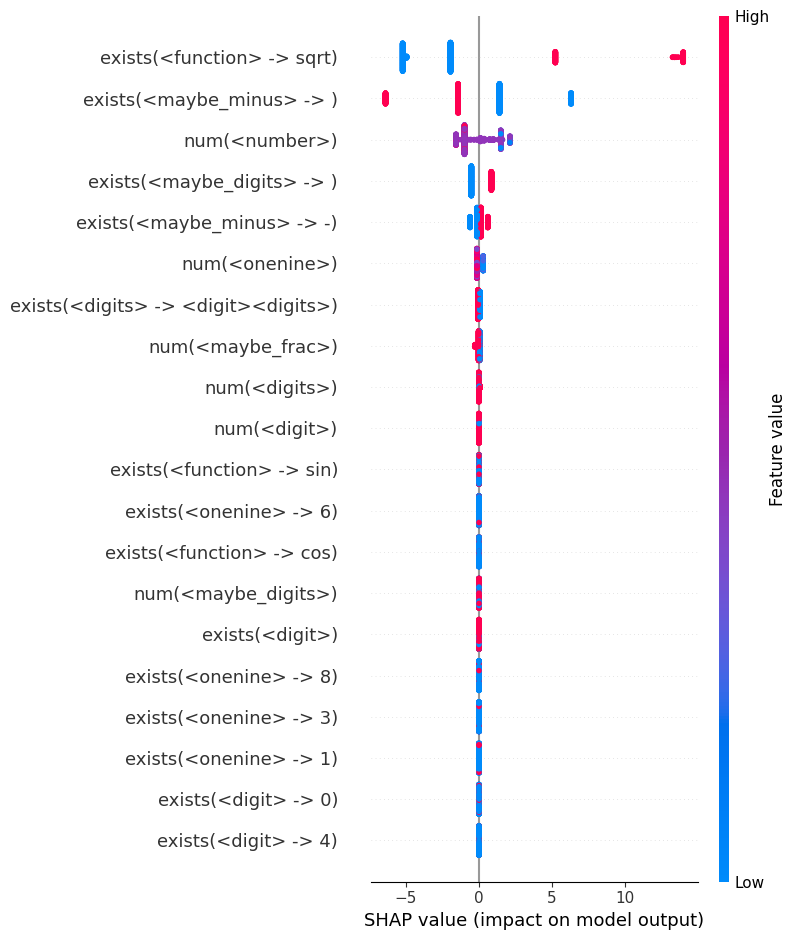

Reduced Set


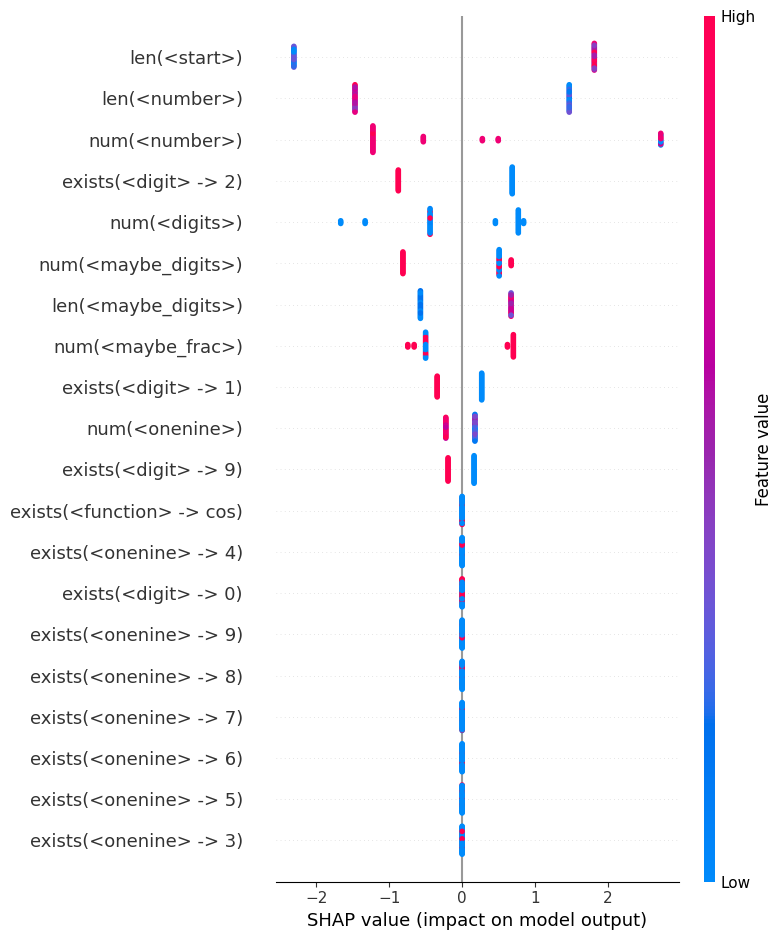

Comparison Set


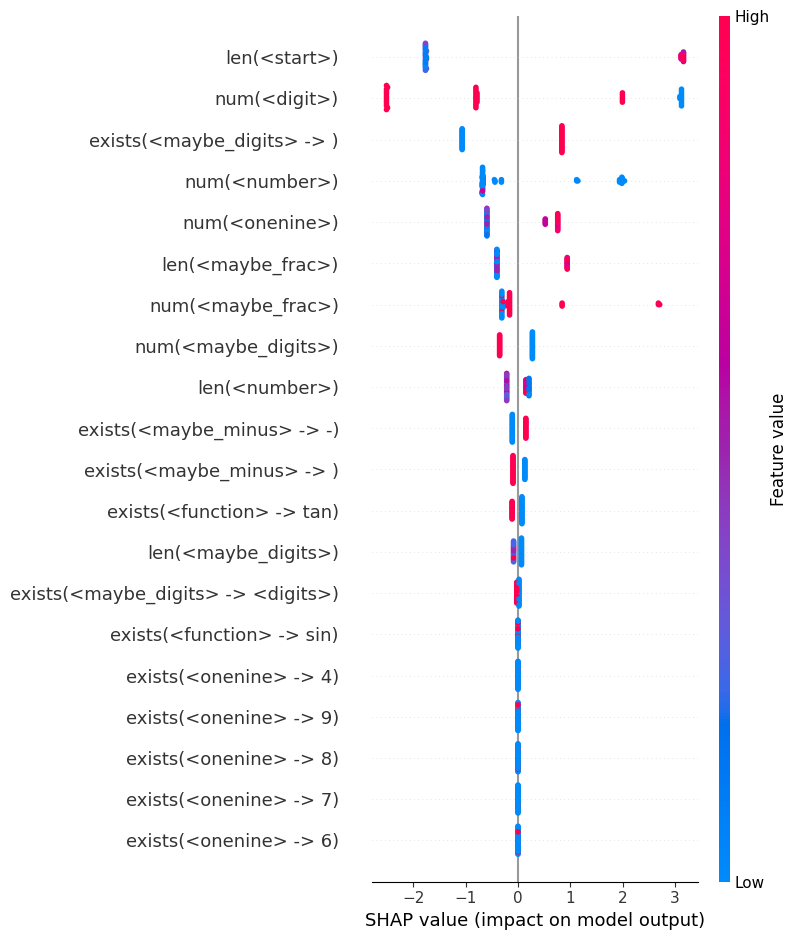

In [35]:
print("Gold standard")
relevant_features_gs, correlating_features_gs, _ = feature_learner.learn(gold_standard_inputs)
print("Reduced Set")
relevant_features_rs, correlating_features_rs, _ = feature_learner.learn(inputs)
print("Comparison Set")
relevant_features_cs, correlating_features_cs, _ = feature_learner.learn(comparison_inputs)

In [22]:
# gold standard
relevant_features_gs, correlating_features_gs

({exists(<function> -> sqrt), exists(<maybe_minus> -> )},
 {exists(<maybe_minus> -> -),
  len(<function>),
  len(<maybe_minus>),
  num(<number>)})

In [23]:
# reduced set
relevant_features_rs, correlating_features_rs

({exists(<function> -> sqrt), len(<start>)}, {len(<function>)})

In [24]:
# comparison set
relevant_features_cs, correlating_features_cs

({len(<start>), num(<maybe_digits>)},
 {exists(<maybe_digits> -> ),
  exists(<maybe_digits> -> <digits>),
  len(<maybe_digits>)})

# Statistical Evaluation

In [9]:
# parameters for statistical evaluation
gold_standard_size = 500
input_steps = 5
max_inputs = 100
executions = 10

# parameters for distance measurements
metric = 1
quantitative_feature_weight = 2
use_PCA = False
mode="dissimilar"

result_set_sizes = range(input_steps, max_inputs + input_steps,input_steps)
exec_range = range(executions)

In [10]:
from avicenna.oracle import OracleResult
from avicenna.input import Input
from avicenna.monads import Exceptional
from avicenna_formalizations.calculator import grammar, oracle, initial_inputs
from avicenna.feature_collector import GrammarFeatureCollector, FeatureVector
from avicenna.features import  ExistenceFeature, NumericFeature, LengthFeature,DerivationFeature
from avicenna import feature_extractor

features = [
    ExistenceFeature,
    NumericFeature,
    DerivationFeature,
    LengthFeature
]

collector = GrammarFeatureCollector(
    grammar, 
    feature_types=features)

feature_learner = feature_extractor.SHAPRelevanceLearner(
    grammar,
    classifier_type=feature_extractor.GradientBoostingTreeRelevanceLearner,
    top_n=2,
    show_beeswarm_plot=False
)

In [11]:
from isla.fuzzer import GrammarFuzzer
from avicenna.input_reducer import determine_input_subset
fuzzer = GrammarFuzzer(grammar)

inp = fuzzer.fuzz_tree()
test_input = Input(inp, oracle(inp))
feature_vector = collector.collect_features(test_input)
features = feature_vector.get_features()
feature_names = [f"{feature}({feature.type.__name__})" for feature in features]

def create_input_sets(gold_standard_size, reduced_size):
    
    gold_standard_inputs = set()
    for _ in range(gold_standard_size):
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
        while new_input in gold_standard_inputs:
            inp = fuzzer.fuzz_tree()
            new_input = Input(inp, oracle(inp))
        gold_standard_inputs.add(new_input)
    
    comparison_inputs = set()
    for _ in range(reduced_size):
        inp = fuzzer.fuzz_tree()
        new_input = Input(inp, oracle(inp))
        while new_input in comparison_inputs:
            inp = fuzzer.fuzz_tree()
            new_input = Input(inp, oracle(inp))
        comparison_inputs.add(new_input)
    
    for inp in gold_standard_inputs:
        inp.update_features(collector.collect_features(inp))
    
    for inp in comparison_inputs:
        inp.update_features(collector.collect_features(inp))

    reduced_inputs = determine_input_subset(gold_standard_inputs, 
                                            grammar, 
                                            reduced_size, 
                                            mode=mode,
                                            feature_types=features,
                                            use_PCA=use_PCA, 
                                            quantitative_feature_weight=quantitative_feature_weight, 
                                            metric=metric)

    return gold_standard_inputs, comparison_inputs, reduced_inputs

def learn_inputs_task(args):
    gs_size, rs_size, i, exec_num = args
    
    # generate sets of inputs
    gs_inputs, cs_inputs, rs_inputs = create_input_sets(gs_size, rs_size)

    # run learner with all three sets
    relevant_features_gs, correlating_features_gs, _ = feature_learner.learn(gs_inputs)
    relevant_features_rs, correlating_features_rs, _ = feature_learner.learn(rs_inputs)
    relevant_features_cs, correlating_features_cs, _ = feature_learner.learn(cs_inputs)

    return i, exec_num, (relevant_features_gs, correlating_features_gs,relevant_features_rs, correlating_features_rs,relevant_features_cs, correlating_features_cs)

In [ ]:
import multiprocessing
from tqdm import tqdm
import numpy as np
from time import time
# generate inputs and learn relevant features for gold standard, reduced set and comparison set
gs_relevant_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)
gs_correlating_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)
rs_relevant_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)
rs_correlating_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)
cs_relevant_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)
cs_correlating_feature_array = np.empty((len(result_set_sizes), len(exec_range)), dtype=object)

########## sequentiell ###########
"""
pbar= tqdm(total=executions * len(result_set_sizes))
for index, reduced_size in enumerate(result_set_sizes):
    for exec_num in exec_range:
        learn_inputs_task((gold_standard_size, reduced_size,index, exec_num))
        pbar.update(1)
"""
############ parallel ############
iterations = []
for index, reduced_size in enumerate(result_set_sizes):
    for exec_num in exec_range:
        iterations.append((gold_standard_size, reduced_size, index, exec_num)) # parallel

num_processes = min(multiprocessing.cpu_count(), len(iterations))
pool = multiprocessing.Pool(processes=num_processes)
chunksize = int(len(iterations) / (num_processes*2))

for result in tqdm(pool.imap(learn_inputs_task, iterations, chunksize = chunksize), total=len(iterations)):
    test_case, exec_num, values = result
    relevant_features_gs, correlating_features_gs, relevant_features_rs, correlating_features_rs, relevant_features_cs, correlating_features_cs = values
    
    gs_relevant_feature_array[test_case, exec_num] = relevant_features_gs
    gs_correlating_feature_array[test_case, exec_num] = correlating_features_gs
    rs_relevant_feature_array[test_case, exec_num] = relevant_features_rs
    rs_correlating_feature_array[test_case, exec_num] = correlating_features_rs
    cs_relevant_feature_array[test_case, exec_num] = relevant_features_cs
    cs_correlating_feature_array[test_case, exec_num] = correlating_features_cs
    
pool.close()
pool.join()
##################################

#save results persitently
%store gs_relevant_feature_array
%store gs_correlating_feature_array
%store rs_relevant_feature_array
%store rs_correlating_feature_array
%store cs_relevant_feature_array
%store cs_correlating_feature_array

  0%|                                                   | 0/200 [00:00<?, ?it/s]

In [9]:
import numpy as np
from tqdm import tqdm 
from multiprocessing import Pool
from avicenna import feature_extractor
result_set_sizes = range(input_steps,max_inputs + 1,input_steps)

# restore results
%store -r gs_relevant_feature_array
%store -r gs_correlating_feature_array
%store -r rs_relevant_feature_array
%store -r rs_correlating_feature_array
%store -r cs_relevant_feature_array
%store -r cs_correlating_feature_array

In [5]:
# Functions for parrallel array operations
array_intersect_cells = np.vectorize(lambda set1, set2: set2 if set1 is None else set1.intersection(set2))
array_union_cells = np.vectorize(lambda set1, set2: set2 if set1 is None else set1.union(set2))
array_cell_count = np.vectorize(lambda set: 0 if set is None else len(set))


# combine relevant and correlating features to one set
gs_complete_feature_array = array_union_cells(gs_relevant_feature_array, gs_correlating_feature_array)
rs_complete_feature_array = array_union_cells(rs_relevant_feature_array, rs_correlating_feature_array)
cs_complete_feature_array = array_union_cells(cs_relevant_feature_array, cs_correlating_feature_array)

# count features per set
gs_feature_cnt = array_cell_count(gs_complete_feature_array)
rs_feature_cnt = array_cell_count(rs_complete_feature_array)
cs_feature_cnt = array_cell_count(cs_complete_feature_array)

total_feature_cnt = len(feature_names)

# calc tp, fp, fn, for all exec_range
rs_true_pos = array_cell_count(array_intersect_cells(rs_complete_feature_array, gs_complete_feature_array))
rs_false_pos = rs_feature_cnt - rs_true_pos
rs_false_neg = gs_feature_cnt - rs_true_pos
rs_true_neg = total_feature_cnt - (rs_true_pos + rs_false_pos + rs_false_neg)
cs_true_pos = array_cell_count(array_intersect_cells(cs_complete_feature_array, gs_complete_feature_array))
cs_false_pos = cs_feature_cnt - cs_true_pos
cs_false_neg = gs_feature_cnt - cs_true_pos
cs_true_neg = total_feature_cnt - (cs_true_pos + cs_false_pos + cs_false_neg)

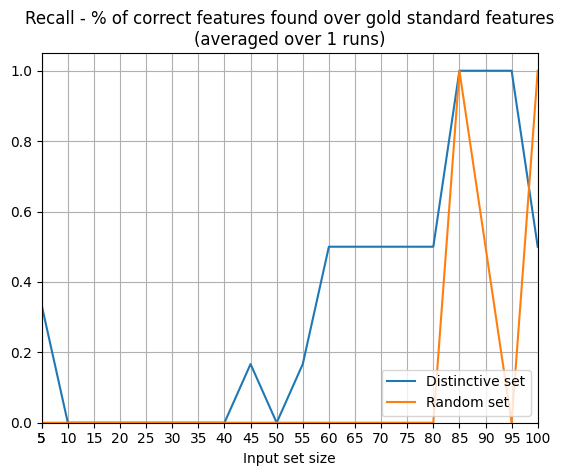

In [6]:
import matplotlib.pyplot as plt

rs_recall = np.where(np.logical_and(rs_true_pos == 0, gs_feature_cnt == 0), 0, np.divide(rs_true_pos, gs_feature_cnt))
cs_recall = np.where(np.logical_and(cs_true_pos == 0, gs_feature_cnt == 0), 0, np.divide(cs_true_pos, gs_feature_cnt))

plt.plot(result_set_sizes, np.mean(rs_recall, axis=1), label="Distinctive set")
plt.plot(result_set_sizes, np.mean(cs_recall, axis=1), label="Random set")
plt.title(f"Recall - % of correct features found over gold standard features\n(averaged over {executions} runs)")
plt.xticks([input_steps]+list(result_set_sizes[::1]))
plt.xlim(result_set_sizes[0],result_set_sizes[-1])
plt.xlabel("Input set size")
plt.ylim(0,1.05)
plt.grid()
plt.legend(loc="lower right")
plt.show()

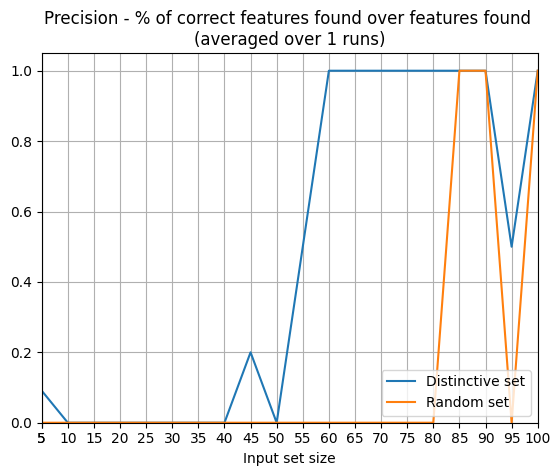

In [7]:
import matplotlib.pyplot as plt

rs_precision = np.where(np.logical_and(rs_true_pos == 0, rs_feature_cnt == 0), 0, np.divide(rs_true_pos, rs_feature_cnt))
cs_precision = np.where(np.logical_and(cs_true_pos == 0, cs_feature_cnt == 0), 0, np.divide(cs_true_pos, cs_feature_cnt))

plt.plot(result_set_sizes, np.mean(rs_precision, axis=1), label="Distinctive set")
plt.plot(result_set_sizes, np.mean(cs_precision, axis=1), label="Random set")
plt.title(f"Precision - % of correct features found over features found \n(averaged over {executions} runs)")

plt.ylim(0,1.05)
plt.xlabel("Input set size")
plt.xticks([input_steps]+list(result_set_sizes[::1]))
plt.xlim(result_set_sizes[0],result_set_sizes[-1])
plt.grid()
plt.legend(loc="lower right")
plt.show()

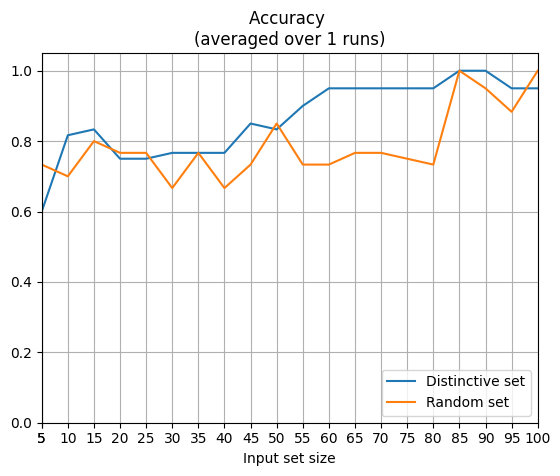

(46.0, 40.0)

In [8]:
import matplotlib.pyplot as plt

rs_accuracy = np.where(total_feature_cnt == 0, 0, np.divide(rs_true_pos + rs_true_neg, total_feature_cnt))
cs_accuracy = np.where(total_feature_cnt == 0, 0, np.divide(cs_true_pos + cs_true_neg, total_feature_cnt))

plt.plot(result_set_sizes, np.mean(rs_accuracy, axis=1), label="Distinctive set")
plt.plot(result_set_sizes, np.mean(cs_accuracy, axis=1), label="Random set")
plt.title(f"Accuracy \n(averaged over {executions} runs)")

plt.ylim(0,1.05)
plt.xlabel("Input set size")
plt.xticks([input_steps]+list(result_set_sizes[::1]))
plt.xlim(result_set_sizes[0],result_set_sizes[-1])
plt.grid()
plt.legend(loc="lower right")
plt.show()
np.mean(rs_true_pos[7] + rs_true_neg[7]), np.mean(cs_true_pos[7] + cs_true_neg[7])